# Sentiment Analysis using Transformer
> Using HuggingFace pretrained transformer models
>>Reference: https://www.ntentional.com/nlp/training%20technique/classification/2020/04/17/fasthugs_seq_classification.html

In [1]:
!pip install fastai2 -q
!pip install transformers -q

     |████████████████████████████████| 194kB 2.8MB/s 
     |████████████████████████████████| 645kB 2.9MB/s 
     |████████████████████████████████| 3.8MB 14.1MB/s 
     |████████████████████████████████| 890kB 35.0MB/s 
     |████████████████████████████████| 1.1MB 46.4MB/s 


In [ ]:
%reload_ext autoreload
%autoreload 2
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from fastai2.basics import *
from fastai2.text.all import *
from fastai2.callback.all import *

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import json

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
model_path = Path('models')
df = pd.read_csv(path/'texts.csv')

In [ ]:
class FastHugsTokenizer():
    """ 
        transformer_tokenizer : takes the tokenizer that has been loaded from the tokenizer class
        model_name : model type set by the user
        max_seq_len : override default sequence length, typically 512 for bert-like models
        sentence_pair : whether a single sentence (sequence) or pair of sentences are used
    """
    def __init__(self, transformer_tokenizer=None, model_name = 'roberta', max_seq_len=None, 
                 sentence_pair=False, **kwargs): 
        self.tok, self.max_seq_len=transformer_tokenizer, max_seq_len
        if self.max_seq_len:
            if self.max_seq_len<=self.tok.max_len: 
                print('WARNING: max_seq_len is larger than the model default transformer_tokenizer.max_len')
        if sentence_pair: self.max_seq_len=ifnone(max_seq_len, self.tok.max_len_sentences_pair) 
        else: self.max_seq_len=ifnone(max_seq_len, self.tok.max_len_single_sentence)
        self.model_name = model_name
        
    def do_tokenize(self, o:str):
        """Limits the maximum sequence length and add the special tokens"""
        CLS, SEP=self.tok.cls_token, self.tok.sep_token
        
        # Add prefix space, depending on model selected
        if 'roberta' in model_name: tokens=self.tok.tokenize(o, add_prefix_space=True)[:self.max_seq_len]
        else: tokens = self.tok.tokenize(o)[:self.max_seq_len]
        
        # order of 'tokens', 'SEP' and 'CLS'
        if 'xlnet' in model_name: return tokens + [SEP] +  [CLS]
        else: return [CLS] + tokens + [SEP]

    def __call__(self, items): 
        for o in items: yield self.do_tokenize(o)

In [ ]:
class FastHugsModel(nn.Module):
    'Inspired by https://www.kaggle.com/melissarajaram/roberta-fastai-huggingface-transformers/data'
    def __init__(self, transformer_cls, config_dict, n_class, pretrained=True):
        super(FastHugsModel, self).__init__()
        self.config = config_dict  
        self.config._num_labels = n_class
        # load model
        if pretrained: self.transformer = transformer_cls.from_pretrained(model_name, config=self.config)
        else: self.transformer = transformer_cls.from_config(config=self.config)
        
    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=1).type(input_ids.type()) 
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0] 
        return logits

### Hugging Face Model + Config:

- `AutoModelForSequenceClassification` will define our model. When this is padded to the `FastHugsModel` class below then model will be instantiated and the weights downloaded (if you are using a pretrained model)
- `AutoConfig` will define the model architecture and settings
- `model_name` is the model architecture (and optionally model weights) you'd like to use.
    - Models tested: `bert-base-uncased`, `roberta-base`, `distilbert-base-cased`, `albert-base-v2`
    - You can find all of HuggingFace's models at [https://huggingface.co/models](https://huggingface.co/models), although not all of them are supported by `AutoModel`,`AutoConfig` and `AutoTokenizer`

In [6]:
model_name = 'roberta-base' 
model_class = AutoModelForSequenceClassification
config_dict = AutoConfig.from_pretrained(model_name)

### HuggingFace Tokenizer & Vocab:

- `AutoTokenizer` will load our tokenizer and enable us grab our vocab

fastai expects `vocab` to be a list, however HuggingFace's `get_vocab` returns a `token : index` dict. We need to convert this dict to a list to be able to use it in fastai

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer_vocab=tokenizer.get_vocab() 
tokenizer_vocab_ls = [k for k, v in sorted(tokenizer_vocab.items(), key=lambda item: item[1])]
len(tokenizer_vocab_ls)

50265

In [8]:
tokenizer_vocab_ls[:10]

['<s>', '<pad>', '</s>', '<unk>', '.', 'Ġthe', ',', 'Ġto', 'Ġand', 'Ġof']

### Model Splitter

In order to be able to fine-tune our classifier head we need to first split the HuggingFace model's classifier head from the body. These functions are dependent on the specific architecture

In [ ]:
from fastai2.basics import *

def bert_cls_splitter(m):
    "Split the classifier head from the backbone"
    groups = [nn.Sequential(m.transformer.bert.embeddings,
                m.transformer.bert.encoder.layer[0],
                m.transformer.bert.encoder.layer[1],
                m.transformer.bert.encoder.layer[2],
                m.transformer.bert.encoder.layer[3],
                m.transformer.bert.encoder.layer[4],
                m.transformer.bert.encoder.layer[5],
                m.transformer.bert.encoder.layer[6],
                m.transformer.bert.encoder.layer[7],
                m.transformer.bert.encoder.layer[8],
                m.transformer.bert.encoder.layer[9],
                m.transformer.bert.encoder.layer[10],
                m.transformer.bert.encoder.layer[11],
                m.transformer.bert.pooler)]
    groups = L(groups + [m.transformer.classifier]) 
    return groups.map(params)


def albert_cls_splitter(m):
    groups = [nn.Sequential(m.transformer.albert.embeddings,
                m.transformer.albert.encoder.embedding_hidden_mapping_in, 
                m.transformer.albert.encoder.albert_layer_groups,
                m.transformer.albert.pooler)]
    groups = L(groups + [m.transformer.classifier]) 
    return groups.map(params)


def distilbert_cls_splitter(m):
    groups = [nn.Sequential(m.transformer.distilbert.embeddings,
                m.transformer.distilbert.transformer.layer[0], 
                m.transformer.distilbert.transformer.layer[1],
                m.transformer.distilbert.transformer.layer[2],
                m.transformer.distilbert.transformer.layer[3],
                m.transformer.distilbert.transformer.layer[4],
                m.transformer.distilbert.transformer.layer[5],
                m.transformer.pre_classifier)]
    groups = L(groups + [m.transformer.classifier]) 
    return groups.map(params)


def roberta_cls_splitter(m):
    "Split the classifier head from the backbone"
    groups = [nn.Sequential(m.transformer.roberta.embeddings,
                  m.transformer.roberta.encoder.layer[0],
                  m.transformer.roberta.encoder.layer[1],
                  m.transformer.roberta.encoder.layer[2],
                  m.transformer.roberta.encoder.layer[3],
                  m.transformer.roberta.encoder.layer[4],
                  m.transformer.roberta.encoder.layer[5],
                  m.transformer.roberta.encoder.layer[6],
                  m.transformer.roberta.encoder.layer[7],
                  m.transformer.roberta.encoder.layer[8],
                  m.transformer.roberta.encoder.layer[9],
                  m.transformer.roberta.encoder.layer[10],
                  m.transformer.roberta.encoder.layer[11],
                  m.transformer.roberta.pooler)]
    groups = L(groups + [m.transformer.classifier])
    return groups.map(params)

splitters = {'bert_cls_splitter':bert_cls_splitter,
            'albert_cls_splitter':albert_cls_splitter,
            'distilbert_cls_splitter':distilbert_cls_splitter,
            'roberta_cls_splitter':roberta_cls_splitter}

In [ ]:
splitter_nm = model_name.split('-')[0] + '_cls_splitter'
model_splitter = splitters[splitter_nm]

### Creating a fastai tokenizer for learner based off HugginFace tokenizer:

In [ ]:
max_seq_len = None  
sentence_pair=False

fasthugstok = partial(FastHugsTokenizer, transformer_tokenizer=tokenizer, model_name=model_name, 
                      max_seq_len=max_seq_len, sentence_pair=sentence_pair)

In [ ]:
fastai_tokenizer = Tokenizer.from_df(text_cols='text', res_col_name='text', tok_func=fasthugstok, rules=[])

### Padding:

We need to make sure our padding is done correctly as some transformer models prefer padding on the left while others prefer it on the right. tokenizer.padding_side will tell us which side is correct. e.g., BERT, Roberta prefers padding to the right, so we set pad_first=False

In [ ]:
def transformer_padding(tokenizer=None, max_seq_len=None, sentence_pair=False): 
    if tokenizer.padding_side == 'right': pad_first=False
    else: pad_first=True
    max_seq_len = ifnone(max_seq_len, tokenizer.max_len) 
    return partial(pad_input_chunk, pad_first=pad_first, pad_idx=tokenizer.pad_token_id, seq_len=max_seq_len)

In [ ]:
bs = 4
padding=transformer_padding(tokenizer)

### Dataloaders:

In [15]:
dls = TextDataLoaders.from_df(df, text_col="text", tok_tfm=fastai_tokenizer, text_vocab=tokenizer_vocab_ls,
                              before_batch=[padding], label_col='label', valid_col='is_valid', bs=bs)

In [16]:
dls.show_batch(max_n=3, trunc_at=60)

,text,category
0,"<s> ĠI Ġwas Ġfortunate Ġenough Ġto Ġmeet ĠGeorge ĠPal Ġ( and Ġstill Ġhave Ġmy ĠDS : TM OB Ġposter Ġaut ographed Ġby Ġhim ) Ġat Ġa Ġconvention Ġshortly Ġafter Ġthe Ġrelease , Ġand Ġasked Ġhim Ġwhy Ġhe Ġchose Ġto Ġdo Ġthe Ġfilm Ġ"" camp "". ĠBefore Ġhe Ġcould Ġanswer , Ġtwo Ġstudio Ġfl acks Ġintercepted Ġand Ġlect ured Ġme Ġon",negative
1,"<s> ĠOh Ġdear Ġ. ĠYet Ġanother Ġexample Ġof Ġ"" ĠO ire land Ġ"" Ġand Ġreligion Ġ. ĠNo Ġdoubt Ġwe 'll Ġbe Ġseeing Ġsome Ġdepressing Ġnonsense Ġfeaturing Ġsome Ġ"" Ġhun ky Ġand Ġmach o Ġfreedom Ġfighters Ġ"" Ġfrom Ġthe ĠIRA Ġ. ĠWell Ġthat Ġwas Ġmy Ġinitial Ġreaction Ġwhen Ġthe Ġcredits Ġstarted Ġbut Ġjust Ġover Ġan Ġhour Ġand Ġa Ġhalf Ġlater ĠI",positive
2,"<s> ĠAre Ġyou Ġfamiliar Ġwith Ġconcept Ġof Ġchildren 's Ġartwork ? ĠWhile Ġit Ġis Ġnot Ġthe Ġgreatest ĠPic asso Ġany Ġthree - year - old Ġhas Ġever Ġaccomplished Ġwith Ġtheir Ġfingers , Ġyou Ġencourage Ġthem Ġto Ġdo Ġmore . ĠIf Ġpainting Ġis Ġwhat Ġmakes Ġthem Ġhappy , Ġthere Ġshould Ġbe Ġno Ġreason Ġa Ġparent Ġshould Ġhold Ġthat Ġback Ġon Ġa",negative


### Learner:

In [ ]:
opt_func = partial(Adam, decouple_wd=True)
loss = LabelSmoothingCrossEntropy()

fasthugs_model = FastHugsModel(transformer_cls=model_class, config_dict=config_dict, n_class=dls.c, pretrained=True)

learn = Learner(dls, fasthugs_model, opt_func=opt_func, splitter=model_splitter, 
                loss_func=loss, metrics=[accuracy]).to_fp16()

### Training:

In [ ]:
# Training only the classifer head
learn.freeze_to(1)

In [19]:
learn.summary()

FastHugsModel (Input shape: ['4 x 512'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            4 x 512 x 768        38,603,520 False     
________________________________________________________________
Embedding            4 x 512 x 768        394,752    False     
________________________________________________________________
Embedding            4 x 512 x 768        768        False     
________________________________________________________________
LayerNorm            4 x 512 x 768        1,536      False     
________________________________________________________________
Dropout              4 x 512 x 768        0          False     
________________________________________________________________
Linear               4 x 512 x 768        590,592    False     
________________________________________________________________
Linear               4 x 512 x 768        590,592    False     
_________________________________________________________

In [20]:
 learn.model

FastHugsModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_feature

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=0.002511886414140463)

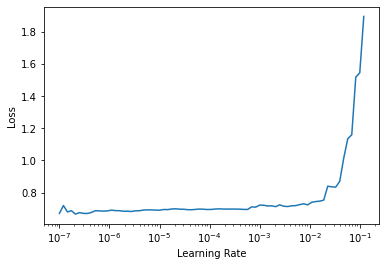

In [21]:
learn.lr_find()

In [35]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.716790,0.660889,0.545000,00:12
1,0.604187,0.597321,0.625000,00:12
2,0.555799,0.548570,0.790000,00:12


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=0.013182567432522774)

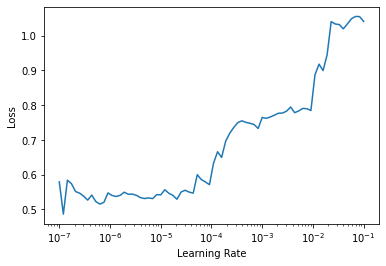

In [36]:
learn.unfreeze()
learn.lr_find()

In [37]:
learn.fit_one_cycle(5, lr_max=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.504427,0.502335,0.845000,00:38
1,0.404284,0.399035,0.885000,00:36
2,0.355813,0.362559,0.915000,00:36
3,0.347731,0.368689,0.895000,00:36
4,0.316477,0.371630,0.895000,00:37


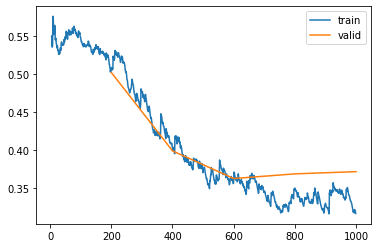

In [38]:
learn.recorder.plot_loss()

In [32]:
learn.predict('The movie was great despite the overall delivery being ok.')

('negative', tensor(0), tensor([0.6742, 0.3258]))

---
---